# Stimulating single fibers with NRV
-----------------------------

In this tutorial, we will create a monofascicular nerve, attach it to one fiber and stimulate it with intra- and extra-fascicular electrodes.
As before, we start by importing the NRV package as well as numpy and matplotlib:

In [1]:
import nrv
import matplotlib.pyplot as plt
import numpy as np
import sys


## Axon definition
Let's start by creating a 10µm myelinated axon, similarly to previous tutorials:

In [2]:
y_a = 0                                                                     #axon y position, in [µm]
z_a = 0                                                                     #axon z position, in [µm]
d_a = 10                                                                    #axon diameter position, in [µm]
n_NoR = 20                                                                  #number of Node-of-Ranvier
L_a = nrv.get_length_from_nodes(d_a, n_NoR)                                 #Get the axon length from number of NoR
axon_m = nrv.myelinated(y_a, z_a, d_a, L_a, model="MRG", rec="nodes")       #we recording only at the node of Ranvier

## Extracellular context Creation

We now need to create the extracellular context of our model, which consists in the nerve and electrode geometry, as well as defining the material properties. Extracellular context instances are created with the ```FEM_stimulation```-class. We can also specify the endoneurium conductivity. Here we will use ```endoneurium_ranck```, and the default value for the other materials.

In [3]:
extra_stim = nrv.FEM_stimulation(endo_mat='endoneurium_ranck')

We can set the diameter of our nerves to 1500µm and length slighly longer than the axon length (to facilitate FEM computation):

In [4]:
d_n = 1500   #in um
extra_stim.reshape_nerve(d_n,L_a*1.2)

Let's also set the diameter of the saline outer box to 10mm: 

In [5]:
d_outbox= 5        #in mm
extra_stim.reshape_outerBox(d_outbox)

And add a 1000µm fascicle in the nerves:

In [6]:
d_f = 1000           #in um
y_f = 0                 #y pos of the fascicle, in um
z_f = 0                 #y pos of the fascicle, in um
extra_stim.reshape_fascicle(Fascicle_D = d_f, y_c=y_f, z_c= z_f)

Finally, we add the electrodes to our FEM models. Let's start by creating a 1000µm in length, 25µm in diameter LIFE electrode. The central point of the LIFE active-site is aligned with the 10th node-of-ranvier of our fiber, and located 100µm away (on the z-axis) from the fiber:

In [7]:
LIFE_d = 25                         # LIFE's diameter, in um
LIFE_l = 1000                       # LIFE's active-site length, in um
x_LIFE = axon_m.x_nodes[n_NoR//2]	# LIFE x position, in [um]
y_LIFE = 0                          # LIFE y position, in [um]
z_LIFE = 100                        # LIFE z position, in [um]
x_LIFE_offset = x_LIFE - (LIFE_l/2)
LIFE = nrv.LIFE_electrode('LIFE_1', LIFE_d, LIFE_l, x_LIFE_offset, y_LIFE, z_LIFE)

Similarly, we create a monopolar cuff-like electrode:

In [8]:
contact_width=500               #width (length) of the cuff active-site, in um
contact_thickness=100           #tickness of the cuff active-site, in um
insulator_width=1000            #width (length) of the cuff insulator, in um
insulator_thickness=500         #tickness of the cuff insulator, in um

x_cuff = axon_m.x_nodes[n_NoR//2] # cuff z position, in [um]
cuff = nrv.CUFF_electrode('CUFF_1', contact_length=contact_width,
        contact_thickness=contact_thickness, insulator_length=insulator_width,
        insulator_thickness=insulator_thickness, x_center=x_cuff)

Before linking our electrodes to their FEM models, we need to setup a stimulus. For that, we create a very basic monophasic cathodic 50µs/50µA pulse:

In [9]:
start = 0.5             #start of the pulse, in ms
I_pulse = 50            #pulse amplitude, in us
T_pulse = 50*1e-3        #pulse duration, in ms
stim1 = nrv.stimulus()
stim1.pulse(start,-I_pulse,T_pulse)

We can plot the stimulus to check it, using built-in plot function of the ```stimulus```class:

Text(0, 0.5, 'amplitude (µA)')

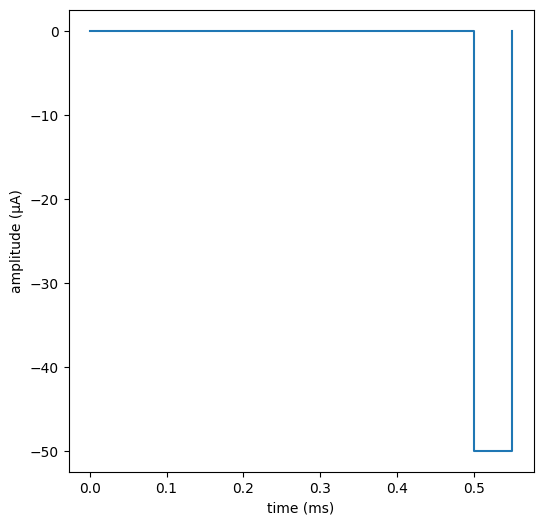

In [10]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
stim1.plot(ax)
ax.set_xlabel("time (ms)")
ax.set_ylabel("amplitude (µA)")

We will also create a dummy stimulus, that we will apply to the electrode we don't want to use

In [11]:
I_pulse_dum = 0.1           #pulse amplitude, in us
T_pulse_dum = 1
dummy_stim = nrv.stimulus()
dummy_stim.pulse(start,-I_pulse_dum,T_pulse_dum)

Electrodes can be simply linked the FEM model by using the ```add_electrode```-method of the ```FEM_stimulation```-object, which combine an ```electrode```-object to a ```stimulus```-object and attach it to the FEM model:

In [12]:
extra_stim.add_electrode(LIFE, stim1)           #ID = 0
extra_stim.add_electrode(cuff, dummy_stim)      #not stim on the cuff - ID = 1

ID of electrode is incremented as we add them to the ``extra_stim``: here the ID for the LIFE is 0 and 1 for the cuff electrode. Let's write it to variable, so we don't mix them later!

In [13]:
ID_LIFE = 0
ID_cuff = 1 

## Connecting the FEM model to the axon and simulating it:
Now it is time to attach the extracellular context to our axon. It can be simply be done with the ``attach_extracellular_stimulation``:

In [14]:
axon_m.attach_extracellular_stimulation(extra_stim)

And simulate it and save the results:

In [15]:
res_LIFE = axon_m(t_sim=3) 

NRV INFO: Mesh properties:
NRV INFO: Number of processes : 3
NRV INFO: Number of entities : 70
NRV INFO: Number of nodes : 9567
NRV INFO: Number of elements : 67397
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: setup the bilinear form
NRV INFO: FEN4NRV: setup the linear form
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 5.293697357177734 s
NRV INFO: Static/Quasi-Static electrical current problem
NRV INFO: FEN4NRV: solving electrical potential
NRV INFO: FEN4NRV: solved in 8.822656393051147 s


We can plot the axon's membrane voltage across time and space with a colormap:

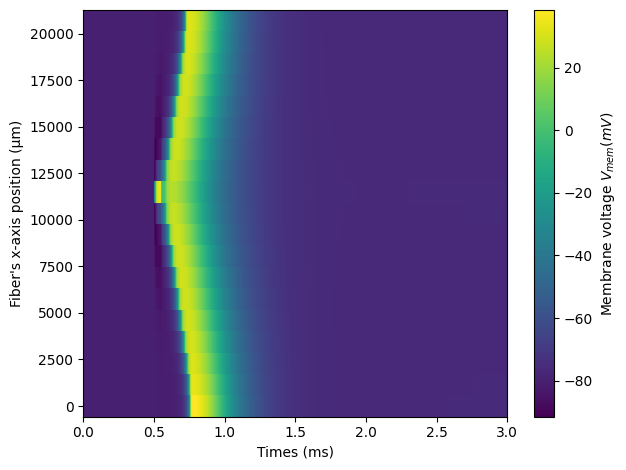

In [16]:
fig, ax = plt.subplots(1)
cbar = res_LIFE.colormap_plot(ax, "V_mem")
ax.set_xlabel('Time (ms)')
ax.set_ylabel("Fiber's x-axis position (µm)")
cbar.set_label(r'Membrane Voltage $V_{mem}$ (mV)')
fig.tight_layout()

We clearly see that the stimulation generated an action potential in the axon! We can automatically detect it with the ``is_recruited`` method of the ``axon_result`` class, which returns true if an AP is detected in the axon:

In [17]:
res_LIFE.is_recruited()

True

Now let's put the ``dummy_stim`` to the LIFE electrode, and re-run the simulation:

In [18]:
axon_m.change_stimulus_from_electrode(ID_LIFE,dummy_stim)
axon_m.change_stimulus_from_electrode(1,dummy_stim)
res_LIFE = axon_m(t_sim=3) 
res_LIFE.is_recruited()

False

As expected, no axon is detected as the axon is not being stimulated! We also observe that the simulation was much faster. Indeed, as long as we do not change the geometrical properties of the model, we do not need to re-run the FEM solver again. 
Let's plot the axon's voltage membrane to verify the statement of the ``is_recruited`` method:

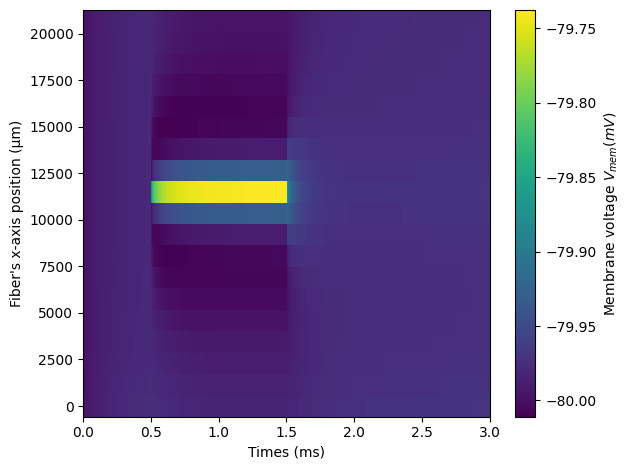

In [19]:
fig, ax = plt.subplots(1)
cbar = res_LIFE.colormap_plot(ax, "V_mem")
ax.set_xlabel('Time (ms)')
ax.set_ylabel("Fiber's x-axis position (µm)")
cbar.set_label(r'Membrane Voltage $V_{mem}$ (mV)')
fig.tight_layout()

And indeed we only see the artifact from the dummy stimulus on the membrane's voltage. Now let's stimulate with the cuff electrode:

In [20]:
axon_m.change_stimulus_from_electrode(ID_cuff,stim1)
res_cuff = axon_m(t_sim=3) 
res_cuff.is_recruited()

False

The axon is not recruited with a 50µs/50µA delivered through the cuff. Let's multiply the stimulation current by four:

In [21]:
axon_m.change_stimulus_from_electrode(ID_cuff,stim1*4)
res_cuff = axon_m(t_sim=3) 
res_cuff.is_recruited()

True

## Stimulation threshold curves

The minimum current required to recruit a fiber is called the activation threshold. This threshold depends upon the type of electrode, the nerve geometry, the axon-to-electrode distance, the shape of the stimulation, the type and diameter of axon, etc. This section describes how to easily find the stimulation threshold of an axon, with a defined extracellular context. For that, we can use the ``firing_threshold_from_axon`` function from NRV.
First, let's put back the ``dummy_sim`` on both electrodes:

In [22]:
axon_m.change_stimulus_from_electrode(ID_cuff,dummy_stim)
axon_m.change_stimulus_from_electrode(ID_LIFE,dummy_stim)

Currently, the ``firing_threshold_from_axon`` function works only with biphasic pulse. We will however stay with our monophasic pulse by setting the anodic current to 0µA. Let's first get the threshold when stimulating with LIFE:

In [23]:
thr_LIFE = nrv.firing_threshold_from_axon(
    axon = axon_m,                              #axon we're looking the threshold of
    cath_time = T_pulse,                        #pulse duration
    elec_id = ID_LIFE,                          #stimulation electrode ID 
    amp_max = 250,                              #maximum amplitude for the search (in µA)
    amp_tol = 5,                                #search tolerance, in %
    t_sim = 3,                                  #stimulation duration, in ms
    cath_an_ratio = 0,                          #cathodic/anodic ratio: 0 --> cathodic only
)
print(f'LIFE threshold: {np.round(thr_LIFE,1)}µA')

NRV INFO: Iteration number 1, testing firing current amplitude 250 uA
NRV INFO: ... Iteration simulation performed in 0.14953279495239258 s
NRV INFO: ... Spike triggered
NRV INFO: Iteration number 2, testing firing current amplitude 0 uA
NRV INFO: ... Iteration simulation performed in 0.1485748291015625 s
NRV INFO: ... Spike not triggered
NRV INFO: Iteration number 3, testing firing current amplitude 125.0 uA
NRV INFO: ... Iteration simulation performed in 0.14812707901000977 s
NRV INFO: ... Spike triggered
NRV INFO: Iteration number 4, testing firing current amplitude 62.5 uA
NRV INFO: ... Iteration simulation performed in 0.14702486991882324 s
NRV INFO: ... Spike triggered
NRV INFO: Iteration number 5, testing firing current amplitude 31.25 uA
NRV INFO: ... Iteration simulation performed in 0.1499006748199463 s
NRV INFO: ... Spike triggered
NRV INFO: Iteration number 6, testing firing current amplitude 15.625 uA
NRV INFO: ... Iteration simulation performed in 0.14605283737182617 s
NR

Let's do the same thing but with the cuff electrode:

In [24]:
axon_m.change_stimulus_from_electrode(ID_LIFE,dummy_stim)   #so LIFE is not stimulating

thr_cuff = nrv.firing_threshold_from_axon(
    axon = axon_m,                              #axon we're looking the threshold of
    cath_time = T_pulse,                        #pulse duration
    elec_id = ID_cuff,                          #stimulation electrode ID 
    amp_max = 500,                              #maximum amplitude for the search (in µA)
    amp_tol = 5,                                #search tolerance, in %
    t_sim = 3,                                  #stimulation duration, in ms
    cath_an_ratio = 0,                          #cathodic/anodic ratio: 0 --> cathodic only
)
print(f'cuff threshold: {np.round(thr_cuff,1)}µA')

NRV INFO: Iteration number 1, testing firing current amplitude 500 uA
NRV INFO: ... Iteration simulation performed in 0.14757108688354492 s
NRV INFO: ... Spike triggered
NRV INFO: Iteration number 2, testing firing current amplitude 0 uA
NRV INFO: ... Iteration simulation performed in 0.14624691009521484 s
NRV INFO: ... Spike not triggered
NRV INFO: Iteration number 3, testing firing current amplitude 250.0 uA
NRV INFO: ... Iteration simulation performed in 0.15514302253723145 s
NRV INFO: ... Spike triggered
NRV INFO: Iteration number 4, testing firing current amplitude 125.0 uA
NRV INFO: ... Iteration simulation performed in 0.1457509994506836 s
NRV INFO: ... Spike not triggered
NRV INFO: Iteration number 5, testing firing current amplitude 187.5 uA
NRV INFO: ... Iteration simulation performed in 0.14886808395385742 s
NRV INFO: ... Spike triggered
NRV INFO: Iteration number 6, testing firing current amplitude 156.25 uA
NRV INFO: ... Iteration simulation performed in 0.1479442119598388

The threshold of LIFE and cuff matches what we observed previously: cuff electrode requires a much higher current than a LIFE to activate a fiber. This result makes sens as extrafascicular electrode have generally a greater electrode-to-axon distance than intrasfascicular one. 

Let's use the ``firing_threshold_from_axon`` function to plot threshold vs axon diameter curve, for both when the axon is stimulated with a LIFE and a cuff. Let's start with the LIFE (takes several minutes to run):

In [25]:
del extra_stim, axon_m                      #to prevent meshing error (known bug)

axon_d_l = [2,4,6,8,10,12,14,16,18,20]        #axon diameter list, in µm
LIFE_thr_l = []                               #list of results
n_NoR = 31                                     #increase NoR so small axons are not too short
nrv.parameters.set_nrv_verbosity(i=2)

for axon_d in axon_d_l:

    #we create a new axon
    L_a = nrv.get_length_from_nodes(axon_d, n_NoR)                              
    new_axon = nrv.myelinated(y=y_a, z=z_a, d=axon_d, L=L_a, model='MRG', rec='nodes')

    #we create a corresponding extracellular context
    extra_stim_f = nrv.FEM_stimulation(endo_mat='endoneurium_ranck')
    extra_stim_f.reshape_nerve(d_n,L_a)
    extra_stim_f.reshape_outerBox(d_outbox)
    extra_stim_f.reshape_fascicle(Fascicle_D = d_f, y_c=y_f, z_c= z_f)

    #same for the LIFE
    x_LIFE = new_axon.x_nodes[n_NoR//2]	# LIFE x position, in [um]
    x_LIFE_offset = x_LIFE - (LIFE_l/2)
    new_LIFE = nrv.LIFE_electrode('LIFE_1', LIFE_d, LIFE_l, x_LIFE_offset, y_LIFE, z_LIFE)
    extra_stim_f.add_electrode(new_LIFE, dummy_stim)  #ID = 0

    #link the extrastim with the axon: 
    new_axon.attach_extracellular_stimulation(extra_stim_f)
    new_axon.get_electrodes_footprints_on_axon()

    thr_LIFE = nrv.firing_threshold_from_axon(axon = new_axon,cath_time = T_pulse, 
    elec_id = 0,amp_max = 100,amp_tol = 2,t_sim = 3,cath_an_ratio = 0, verbose = False)  
    del extra_stim_f, new_axon                       #to prevent meshing error (known bug)

    print(f'LIFE threshold: {np.round(thr_LIFE,1)}µA (axon_d = {axon_d}µm)')                        
    LIFE_thr_l.append(thr_LIFE)


NRV WARNING: [6000.00537109    0.            0.        ] not found in mesh, value of [6000.    0.    0.] reused
LIFE threshold: 69.1µA (axon_d = 2µm)
LIFE threshold: 35.0µA (axon_d = 4µm)
LIFE threshold: 23.6µA (axon_d = 6µm)
LIFE threshold: 18.7µA (axon_d = 8µm)
LIFE threshold: 16.3µA (axon_d = 10µm)
LIFE threshold: 15.3µA (axon_d = 12µm)
LIFE threshold: 14.9µA (axon_d = 14µm)
LIFE threshold: 14.4µA (axon_d = 16µm)
LIFE threshold: 14.0µA (axon_d = 18µm)
LIFE threshold: 13.6µA (axon_d = 20µm)


Let's to the same curve but with a cuff electrode this time:

In [26]:
cuff_thr_l = []                               #list of results

for axon_d in axon_d_l:

    #we create a new axon
    L_a = nrv.get_length_from_nodes(axon_d, n_NoR)                              
    new_axon = nrv.myelinated(y=y_a, z=z_a, d=axon_d, L=L_a, model='MRG', rec='nodes')

    #we create a corresponding extracellular context
    extra_stim_f = nrv.FEM_stimulation(endo_mat='endoneurium_ranck')
    extra_stim_f.reshape_nerve(d_n,L_a)
    extra_stim_f.reshape_outerBox(d_outbox)
    extra_stim_f.reshape_fascicle(Fascicle_D = d_f, y_c=y_f, z_c= z_f)

    #same for the LIFE
    x_cuff = new_axon.x_nodes[n_NoR//2] # cuff z position, in [um]
    new_cuff = nrv.CUFF_electrode('CUFF_1', contact_length=contact_width,
            contact_thickness=contact_thickness, insulator_length=insulator_width,
            insulator_thickness=insulator_thickness, x_center=x_cuff)
    extra_stim_f.add_electrode(new_cuff, dummy_stim)  #ID = 0

    #link the extrastim with the axon: 
    new_axon.attach_extracellular_stimulation(extra_stim_f)
    new_axon.get_electrodes_footprints_on_axon()

    thr_cuff = nrv.firing_threshold_from_axon(axon = new_axon,cath_time = T_pulse, 
    elec_id = 0,amp_max = 1500,amp_tol = 2,t_sim = 3,cath_an_ratio = 0, verbose = False)  
    del extra_stim_f, new_axon                       #to prevent meshing error (known bug)

    print(f'cuff threshold: {np.round(thr_cuff,1)}µA (axon_d = {axon_d}µm)')                        
    cuff_thr_l.append(thr_cuff)

NRV WARNING: [6000.00537109    0.            0.        ] not found in mesh, value of [6000.    0.    0.] reused
LIFE threshold: 1394.5µA (axon_d = 2µm)
LIFE threshold: 518.6µA (axon_d = 4µm)
LIFE threshold: 284.2µA (axon_d = 6µm)
LIFE threshold: 197.8µA (axon_d = 8µm)
LIFE threshold: 156.7µA (axon_d = 10µm)
LIFE threshold: 138.4µA (axon_d = 12µm)
LIFE threshold: 128.2µA (axon_d = 14µm)
LIFE threshold: 119.4µA (axon_d = 16µm)
LIFE threshold: 112.1µA (axon_d = 18µm)
LIFE threshold: 107.7µA (axon_d = 20µm)


Now we can plot the results to compare the recruitment properties of the two tested electrodes:

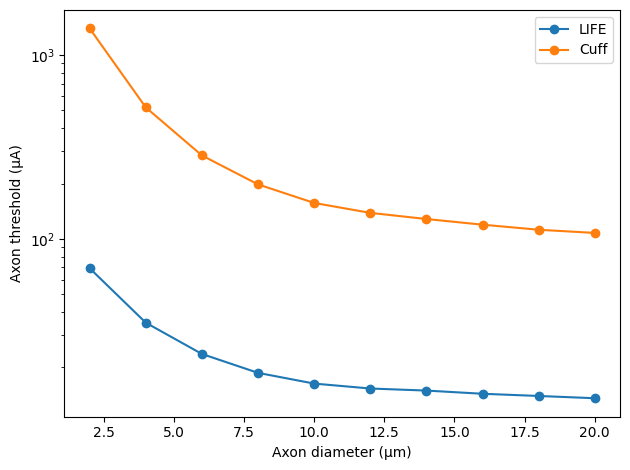

In [30]:
plt.figure()
plt.semilogy(axon_d_l,LIFE_thr_l,'o-',label = 'LIFE')
plt.semilogy(axon_d_l,cuff_thr_l,'o-',label = 'Cuff')
plt.legend()
plt.xlabel("Axon diameter (µm)")
plt.ylabel("Axon threshold (µA)")
plt.tight_layout()
#plt.show()